In [4]:
import pandas as pd
import numpy as np
from datetime import datetime
from pandas import to_datetime
import matplotlib.pyplot as plt
import time
import seaborn as sns
import pmdarima as pm
from pmdarima.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [5]:
# 포트폴리오 관련 library import

import cvxopt as opt # python version 3.6-3.10 가능
from cvxopt import solvers
from pypfopt.efficient_frontier import EfficientFrontier # 정확하게는 모르겠는데 3.7은 사용가능
from pypfopt import risk_models
from pypfopt import expected_returns

In [27]:
df = pd.read_csv("C:/Users/User/github/Web_crawling/save_data/stock_data.csv", encoding='cp949')

In [28]:
df.set_index('time', inplace=True)

In [29]:
# train 데이터와 validation 데이터 나누기.
X_train = df[df.index < '2019-01-01']
X_valid = df[df.index >= '2019-01-01']

# 각 데이터의 사이즈 확인하기
print('X_train Shape', X_train.shape)
print('X_Valid Shape', X_valid.shape)

X_train Shape (180, 21)
X_Valid Shape (48, 21)


---
#### train 구간만 사용한 포트폴리오와 예측 구간까지 사용한 포트폴리오의 차이를 확인할 것임
#### train 구간이 움직일때 포트폴리오를 다시 최적화 할것임.
#### 즉 한달 주기로 포트폴리오를 다시 구성한다고 생각하면 될것.
#### 수수료는 없다고 가정
#### 처음 주식을 구매하고 주식을 전부 판매하고 다시 주식을 구매하는 것으로 돈을 계속 계산할 것임

In [107]:
weights = np.ones(21) # 초기에 가중치를 1로 설정
weights = weights/21 # 이후 동일하게 1/22으로 나눠서 설정 (가중치 합은 항상 1)

returns=X_train.pct_change() # 단순 수익률 계산 => (다음날 값 +- 기준일 값)/기준일 값 으로 수익률 나옵니다.

cov_matrix_annual=returns.cov()*12 # 데이터 기준이 DAY가 아니라 MONTH이므로 12를 곱해 연간 수익률로 계산

port_variance= weights.T @ cov_matrix_annual @ weights # 포트폴리오 분산의 기대값 = WT * (공분산{= 시그마}) * W를 코드로 옆처럼 나타냄

port_volatility=np.sqrt(port_variance) # 포트폴리오 변동성의 기대값 = SQRT(WT * 공분산(=시그마) * W) // 그냥 표준편차 = 변동성

portfolioSimpleAnnualReturn=np.sum(returns.mean()*weights)*12 # 연간 수익률 계산 DAY가 아니라 MONTH기준이므로 12곱하면 됨

In [108]:
percent_var=str(round(port_variance,2)*100)+'%'
percent_vol=str(round(port_volatility,2)*100)+'%'
percent_ret=str(round(portfolioSimpleAnnualReturn,2)*100)+'%'

In [109]:
print('Expected Annual Return :'+ percent_ret )
print('Annual Volatility/risk :'+ percent_vol )
print('Annual Variance :'+ percent_var )

Expected Annual Return :9.0%
Annual Volatility/risk :19.0%
Annual Variance :4.0%


In [35]:
1000000000000*weights/ X_train.iloc[-1,:] @ X_valid.iloc[-1,:]

1017609252337.6196

In [77]:
# Portfolio optimization

# Calculate the expexted returns and annualised sample covariance matrix of the asset returns
mu=expected_returns.mean_historical_return(X_train, frequency=12) # 앞과 동일하게 data가 month기준
S=risk_models.sample_cov(X_train, frequency= 12) # 앞과 동일하게 data가 month기준

# Optimize the max sharpe ratio
ef = EfficientFrontier(mu, S)
#weights = ef.min_volatility()
#weights = ef.max_sharpe()
weights = ef.max_quadratic_utility() 
cleaned_weights = ef.clean_weights() 
print(cleaned_weights) #Note the weights may have some rounding error, meaning they may not add up exactly to 1 but should be close
ef.portfolio_performance(verbose=True)

OrderedDict([('음식료품', 0.0), ('섬유의복', 0.0), ('종이목재', 0.0), ('화학', 0.0), ('의약품', 1.0), ('비금속광물', 0.0), ('철강금속', 0.0), ('기계', 0.0), ('전기전자', 0.0), ('의료정밀', 0.0), ('운수장비', 0.0), ('유통업', 0.0), ('전기가스업', 0.0), ('건설업', 0.0), ('운수창고업', 0.0), ('통신업', 0.0), ('금융업', 0.0), ('은행', 0.0), ('증권', 0.0), ('보험', 0.0), ('서비스업', 0.0)])
Expected annual return: 16.6%
Annual volatility: 29.1%
Sharpe Ratio: 0.50


(0.16567436723773787, 0.2913281669739491, 0.500035299541648)

In [78]:
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

latest_prices = get_latest_prices(X_train)
weights = cleaned_weights 

da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=1000000000000)
allocation, leftover = da.lp_portfolio()

print("Discrete allocation:", allocation) # 해당주를 얼마나 구입하는가
print("Funds remaining: ${:.2f}".format(leftover)) # 예상 수익

Discrete allocation: {'의약품': 86009001}
Funds remaining: $8163.31


In [79]:
l = pd.DataFrame(index=range(0,1), columns = df.columns)
l_2 = pd.merge(l, pd.DataFrame.from_dict(data = allocation, orient='index', dtype='int').T, how = 'outer').fillna(0)
l_2.iloc[1,:]@X_valid.iloc[-1,:].T # 포트폴리오 실제 수익

1186393538263.83

In [80]:
b = 1000000000
solution_2 = []
money_2 = []
sol_2 = pd.DataFrame(index=range(0,1), columns = df.columns)
for i in range(0,13):
    if i == 0:
        latest_prices_2 = get_latest_prices(X_train)
        weights_2 = cleaned_weights
    else: 
        latest_prices_2 = get_latest_prices(pd.concat([X_train, pd.DataFrame(X_valid.iloc[i,:]).T]))
        weights_2 = cleaned_weights 

    da = DiscreteAllocation(weights_2, latest_prices_2, total_portfolio_value=b)
    solution_2.append(da.lp_portfolio())
    money_2.append(b)
    sol_2 = pd.merge(sol_2, pd.DataFrame.from_dict(data = solution_2[i][0], orient='index', dtype='int').T, how = 'outer').fillna(0) 
    b += pd.DataFrame(solution_2).iloc[i,1]*1200

In [41]:
pd.concat([X_train, pd.DataFrame(X_valid.iloc[i,:]).T])

,음식료품,섬유의복,종이목재,화학,의약품,비금속광물,철강금속,기계,전기전자,의료정밀,...,유통업,전기가스업,건설업,운수창고업,통신업,금융업,은행,증권,보험,서비스업
2004-01-31,1301.41,87.67,181.95,1030.53,1181.26,850.49,1788.47,404.42,5205.42,393.51,...,224.08,604.60,63.13,972.18,335.00,263.87,191.01,1069.30,5300.97,355.96
2004-02-29,1273.45,87.14,204.97,1116.18,1269.49,832.06,1963.28,439.56,5379.51,350.31,...,223.29,621.45,65.84,944.13,349.87,284.40,203.09,1121.27,5538.77,368.91
2004-03-31,1258.50,82.87,206.01,1110.90,1241.57,807.16,1851.05,444.92,5685.00,350.07,...,216.23,611.06,65.94,888.41,325.26,270.62,187.51,1064.50,5818.82,389.92
2004-04-30,1334.90,83.46,189.07,1139.42,1277.78,835.93,1674.74,400.92,5533.12,329.70,...,253.01,603.30,66.44,802.05,307.35,260.67,182.69,996.81,5895.44,417.70
2004-05-31,1218.45,75.89,169.21,1091.50,1146.92,736.18,1586.80,359.56,5006.79,299.32,...,265.51,585.04,59.31,774.69,298.39,237.73,171.75,844.79,5455.42,400.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-30,4077.32,320.06,437.57,5600.71,14878.96,1896.78,4713.97,925.36,17394.10,3420.39,...,452.20,1010.99,125.98,1365.18,416.70,491.16,325.61,1915.34,18265.86,1176.32
2018-10-31,3665.33,257.27,351.07,4646.56,10867.84,1495.08,3972.97,736.80,15784.05,2545.36,...,378.12,919.84,97.27,1234.62,387.57,438.85,309.62,1587.19,17269.98,1017.88
2018-11-30,3961.63,259.91,351.57,4887.66,11381.22,1674.10,4028.74,771.38,15678.44,2462.30,...,394.82,981.80,109.17,1333.94,418.78,448.83,308.11,1767.51,16711.13,1127.99
2018-12-31,3960.01,253.51,357.66,4874.93,11626.69,1661.05,4043.12,765.14,14447.02,2133.84,...,393.50,1050.60,112.60,1341.29,397.99,434.35,300.61,1675.55,16303.29,1080.00


In [42]:
money_2

[1000000000,
 1000893808.0001831,
 1001036236.2198353,
 1001104252.0219326,
 1002316386.341238,
 1002570691.8269157,
 1010696404.1259766,
 1011020855.2978516,
 1012955432.7197552,
 1013054024.4260311,
 1015416879.6635151,
 1016745091.8817043,
 1016990733.9268208]

Text(0.5, 1.0, '포트폴리오 업데이트 횟수별 예상 누적 수익 변화')

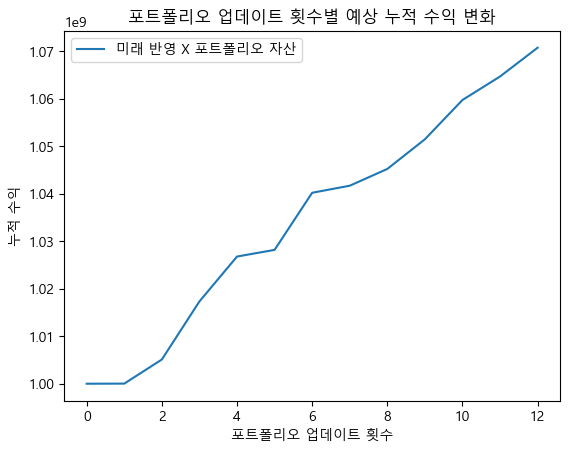

In [81]:
#plt.plot((pd.DataFrame(money)), label = '미래 반영 포트폴리오 자산')
plt.plot((pd.DataFrame(money_2)), label = '미래 반영 X 포트폴리오 자산')
plt.xlabel('포트폴리오 업데이트 횟수')
plt.ylabel('누적 수익')
plt.legend()
plt.title('포트폴리오 업데이트 횟수별 예상 누적 수익 변화')

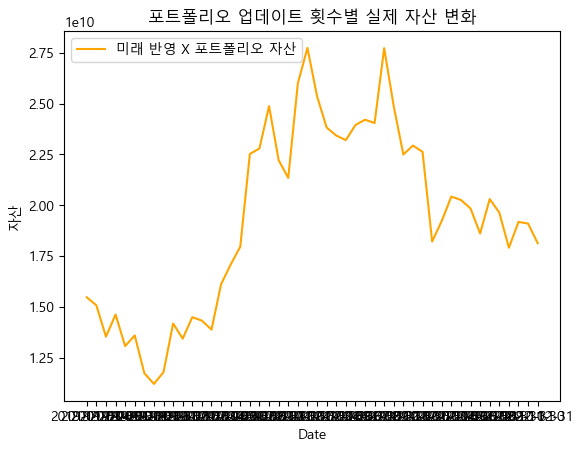

In [82]:
#plt.plot((sol@predict.T).sum(), label ='미래 반영 포트폴리오 자산')
plt.plot((sol_2@X_valid.T).sum(), label = '미래 반영 X 포트폴리오 자산', color = 'orange')
plt.legend()
plt.xlabel('Date')
plt.ylabel('자산')
plt.title('포트폴리오 업데이트 횟수별 실제 자산 변화')
plt.show()

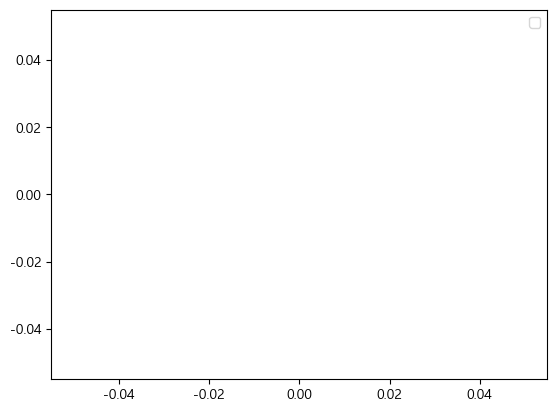

In [54]:
for i in range(len(sol.columns)):
    globals()['h{}'.format(i)] = plt.plot(sol.iloc[:,i])
    'h{}'.format(i)
plt.legend(handles=(h2, h3, h4, h5, h9, h10, h18),labels = {'섬유의복','종이목재','화학','의약품','전기전자','의료정밀','은행'}, loc='best' )
plt.show()
# 범례 안보임..

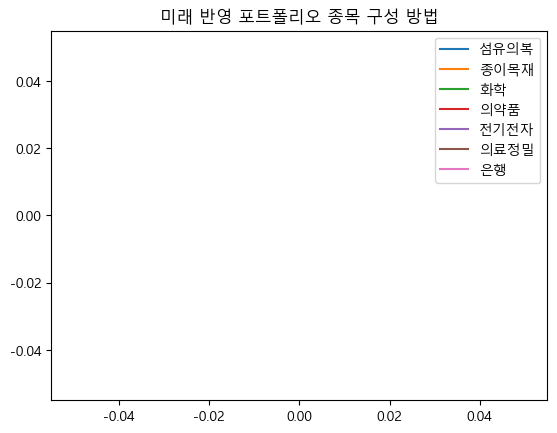

In [46]:
plt.plot(sol.iloc[:,2], label = '섬유의복')
plt.plot(sol.iloc[:,3], label = '종이목재')
plt.plot(sol.iloc[:,4], label = '화학')
plt.plot(sol.iloc[:,5], label = '의약품')
plt.plot(sol.iloc[:,9], label = '전기전자')
plt.plot(sol.iloc[:,10], label = '의료정밀')
plt.plot(sol.iloc[:,18], label = '은행')
plt.legend()
plt.title('미래 반영 포트폴리오 종목 구성 방법')
plt.show()

In [56]:
sol_2.sum()!=0

음식료품      True
섬유의복      True
종이목재     False
화학        True
의약품      False
비금속광물    False
철강금속     False
기계        True
전기전자      True
의료정밀     False
운수장비     False
유통업      False
전기가스업     True
건설업      False
운수창고업    False
통신업       True
금융업      False
은행        True
증권       False
보험        True
서비스업      True
dtype: bool

In [59]:
solution_2

[({'음식료품': 64189,
   '섬유의복': 64567,
   '화학': 443,
   '전기전자': 13801,
   '전기가스업': 84702,
   '통신업': 957913,
   '보험': 250,
   '서비스업': 49626},
  2.3600000143051147),
 ({'음식료품': 63326,
   '섬유의복': 57182,
   '화학': 410,
   '전기전자': 11956,
   '전기가스업': 80716,
   '통신업': 1016318,
   '보험': 233,
   '서비스업': 46770},
  198.3000169992447),
 ({'음식료품': 62772,
   '섬유의복': 52397,
   '화학': 422,
   '전기전자': 12019,
   '전기가스업': 92166,
   '통신업': 1043002,
   '보험': 238,
   '서비스업': 46688},
  7.63041615486145),
 ({'음식료품': 63693,
   '섬유의복': 51330,
   '화학': 420,
   '전기전자': 11613,
   '전기가스업': 95778,
   '통신업': 1070174,
   '보험': 237,
   '서비스업': 46225},
  120.61980211734772),
 ({'음식료품': 69761,
   '섬유의복': 55928,
   '화학': 463,
   '전기전자': 12730,
   '전기가스업': 104574,
   '통신업': 1065217,
   '보험': 261,
   '서비스업': 49104},
  16.07234299182892),
 ({'음식료품': 67978,
   '섬유의복': 54877,
   '화학': 457,
   '전기전자': 11684,
   '전기가스업': 105425,
   '통신업': 1035086,
   '보험': 263,
   '서비스업': 48221},
  272.89393305778503),
 ({'음식료품': 73731,
   '섬유의복': 57

In [58]:
sol_2

,음식료품,섬유의복,종이목재,화학,의약품,비금속광물,철강금속,기계,전기전자,의료정밀,...,유통업,전기가스업,건설업,운수창고업,통신업,금융업,은행,증권,보험,서비스업
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,64189.0,64567.0,0.0,443.0,0.0,0.0,0.0,0.0,13801.0,0.0,...,0.0,84702.0,0.0,0.0,957913.0,0.0,0.0,0.0,250.0,49626.0
2,63326.0,57182.0,0.0,410.0,0.0,0.0,0.0,0.0,11956.0,0.0,...,0.0,80716.0,0.0,0.0,1016318.0,0.0,0.0,0.0,233.0,46770.0
3,62772.0,52397.0,0.0,422.0,0.0,0.0,0.0,0.0,12019.0,0.0,...,0.0,92166.0,0.0,0.0,1043002.0,0.0,0.0,0.0,238.0,46688.0
4,63693.0,51330.0,0.0,420.0,0.0,0.0,0.0,0.0,11613.0,0.0,...,0.0,95778.0,0.0,0.0,1070174.0,0.0,0.0,0.0,237.0,46225.0
5,69761.0,55928.0,0.0,463.0,0.0,0.0,0.0,0.0,12730.0,0.0,...,0.0,104574.0,0.0,0.0,1065217.0,0.0,0.0,0.0,261.0,49104.0
6,67978.0,54877.0,0.0,457.0,0.0,0.0,0.0,0.0,11684.0,0.0,...,0.0,105425.0,0.0,0.0,1035086.0,0.0,0.0,0.0,263.0,48221.0
7,73731.0,57282.0,0.0,478.0,0.0,0.0,0.0,0.0,11955.0,0.0,...,0.0,98811.0,0.0,0.0,1088603.0,0.0,0.0,0.0,283.0,48468.0
8,78246.0,61481.0,0.0,495.0,0.0,0.0,0.0,0.0,12259.0,0.0,...,0.0,107633.0,0.0,0.0,1115167.0,0.0,0.0,0.0,316.0,47974.0
9,73785.0,57496.0,0.0,486.0,0.0,0.0,0.0,0.0,11241.0,0.0,...,0.0,106525.0,0.0,0.0,1100658.0,0.0,9.0,0.0,310.0,47204.0


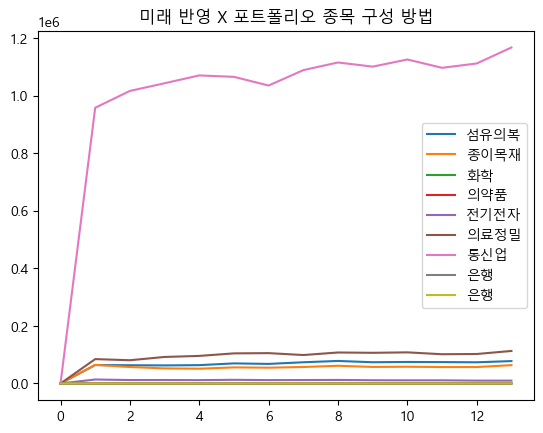

In [57]:
plt.plot(sol_2.iloc[:,0], label = '섬유의복')
plt.plot(sol_2.iloc[:,1], label = '종이목재')
plt.plot(sol_2.iloc[:,3], label = '화학')
plt.plot(sol_2.iloc[:,7], label = '의약품')
plt.plot(sol_2.iloc[:,8], label = '전기전자')
plt.plot(sol_2.iloc[:,12], label = '의료정밀')
plt.plot(sol_2.iloc[:,15], label = '통신업')
plt.plot(sol_2.iloc[:,17], label = '은행')
plt.plot(sol_2.iloc[:,19], label = '은행')

plt.legend()
plt.title('미래 반영 X 포트폴리오 종목 구성 방법')
plt.show()

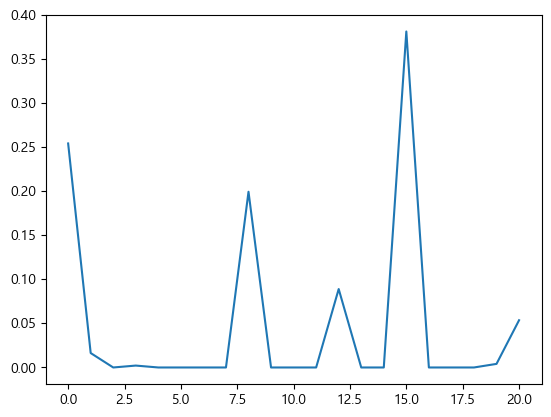

In [75]:
plt.plot(dict(cleaned_weights).values())

(array([[2., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 2., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 2., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 2., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],


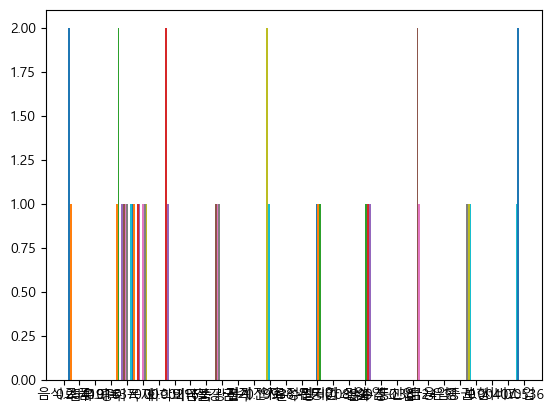

In [70]:
plt.hist(cleaned_weights.items())

TypeError: unhashable type: 'numpy.ndarray'

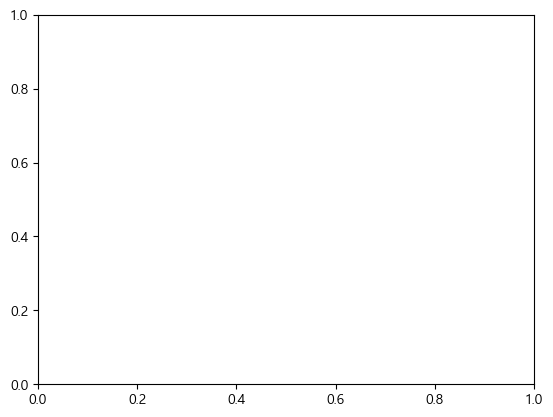

In [71]:
plt.plot(cleaned_weights.items())